# Neural Networks with Custom Datasets

In [6]:
import os, glob, random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import GaussianBlur, ToTensor, Compose, Lambda
from torchvision.utils import make_grid
from torchsummary import summary

In [7]:
def set_seed(seed):
    """Set ALL the random seeds to a fixed value and take out any randomness from cuda kernels."""

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms.
                                            # Useful when inputs do not change size.
    torch.backends.cudnn.enabled   = False

    return True

In [8]:
def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    return device

device = set_device("cuda")

No GPU available! Running on CPU


## Custom datasets

`torch.utils.data.Dataset` เป็น abstract class ของ dataset

Dataset ต่าง ๆ ใน `PyTorch` (เช่น `MNIST`) ก็สืบทอดมาจาก class นี้

เราสามารถเขียน class ใหม่ที่สืบทอดมาจาก `Dataset` class สำหรับ dataset ของตัวเองได้ โดยต้อง override method ต่อไปนี้
- `__len__`: return the size of the dataset
- `__getitem__`: support indexing (dataset[i] ต้อง return ข้อมูลตำแหน่งที่ i)

### Example: butterfly dataset

ไปยัง directory ที่มีไฟล์ `kaggle.json` และรันคำสั่งต่อไปนี้ใน Terminal เพื่อดาวน์โหลด dataset จาก Kaggle (ต้องทำ <a href="https://www.kaggle.com/docs/api">authentication</a> ก่อน)

```
mkdir ~/.kaggle
cp ./kaggle.json ~/.kaggle
kaggle datasets download -d gpiosenka/butterfly-images40-species
mkdir ./butterfly-images40-species
unzip -q butterfly-images40-species.zip -d ./butterfly-images40-species
```

หากทำใน Google Colab ให้รันคำสั่งเหล่านี้แทน
```
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle
!kaggle datasets download -d gpiosenka/butterfly-images40-species
!mkdir ./butterfly-images40-species
!unzip -q butterfly-images40-species.zip -d ./butterfly-images40-species
```

In [9]:
# Import butterfly train dataset
butterfly_train_dataset = ImageFolder("../data/butterfly-images40-species/train/")

In [10]:
# Print the information about the dataset
print(butterfly_train_dataset, "\n")
print(butterfly_train_dataset.class_to_idx)

Dataset ImageFolder
    Number of datapoints: 12594
    Root location: ../data/butterfly-images40-species/train/ 

{'ADONIS': 0, 'AFRICAN GIANT SWALLOWTAIL': 1, 'AMERICAN SNOOT': 2, 'AN 88': 3, 'APPOLLO': 4, 'ARCIGERA FLOWER MOTH': 5, 'ATALA': 6, 'ATLAS MOTH': 7, 'BANDED ORANGE HELICONIAN': 8, 'BANDED PEACOCK': 9, 'BANDED TIGER MOTH': 10, 'BECKERS WHITE': 11, 'BIRD CHERRY ERMINE MOTH': 12, 'BLACK HAIRSTREAK': 13, 'BLUE MORPHO': 14, 'BLUE SPOTTED CROW': 15, 'BROOKES BIRDWING': 16, 'BROWN ARGUS': 17, 'BROWN SIPROETA': 18, 'CABBAGE WHITE': 19, 'CAIRNS BIRDWING': 20, 'CHALK HILL BLUE': 21, 'CHECQUERED SKIPPER': 22, 'CHESTNUT': 23, 'CINNABAR MOTH': 24, 'CLEARWING MOTH': 25, 'CLEOPATRA': 26, 'CLODIUS PARNASSIAN': 27, 'CLOUDED SULPHUR': 28, 'COMET MOTH': 29, 'COMMON BANDED AWL': 30, 'COMMON WOOD-NYMPH': 31, 'COPPER TAIL': 32, 'CRECENT': 33, 'CRIMSON PATCH': 34, 'DANAID EGGFLY': 35, 'EASTERN COMA': 36, 'EASTERN DAPPLE WHITE': 37, 'EASTERN PINE ELFIN': 38, 'ELBOWED PIERROT': 39, 'EMPEROR GUM MO

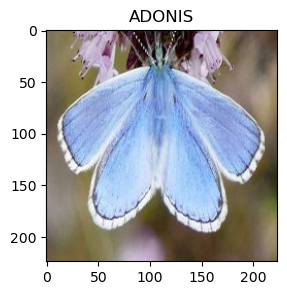

In [11]:
butterfly, target = butterfly_train_dataset[42]
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(butterfly)
ax.set(title=list(butterfly_train_dataset.class_to_idx)[0]);

เราต้องการเบลอภาพผีเสื้อใน dataset เพื่อใช้เป็น input สำหรับทำ deblurring task ต่อไป 

In [12]:
class BlurredButterflyDataset(Dataset):
    """Class to blur the dataset."""

    def __init__(self, root, kernel_size, sigma=(0.1, 2.0), transform=None):
        self.transform = transform
        self.root = root
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.data_paths = self._get_image_paths()

    def _get_image_paths(self, exts=(".jpeg", ".jpg", ".png")):
        data_paths = []
        for root, dirs, files in os.walk(self.root):
            for file in files:
                if(file.endswith(exts)):
                    data_paths.append(os.path.join(root,file))
        return data_paths

    def __getitem__(self, idx):
        # Load image
        img_path = self.data_paths[idx]
        img = Image.open(img_path).convert("RGB")

        # Let's make to Tensor compulsory so we can manipulate the image as a tensor inside __getitem__
        img = ToTensor()(img)

        # Apply other transforms
        if self.transform:
            img = self.transform(img)

        # Blurred image
        blurred_img = GaussianBlur(kernel_size=self.kernel_size, sigma=self.sigma)(img)

        return blurred_img, img

    def __len__(self):
        return len(self.data_paths)

    def __str__(self):
        class_string = ""
        class_string += self.__class__.__name__
        class_string+="\n\tlen : %d"%self.__len__()
        for key, value in self.__dict__.items():
            if key != "data_paths":
                class_string+="\n\t" + str(key) + " : " + str(value)
        return class_string

In [13]:
butterfly_train_dataset = BlurredButterflyDataset(
    root="../data/butterfly-images40-species/train/",
    kernel_size=(5, 5),
    sigma=(2, 2)
)
print(butterfly_train_dataset)

BlurredButterflyDataset
	len : 12594
	transform : None
	root : ../data/butterfly-images40-species/train/
	kernel_size : (5, 5)
	sigma : (2, 2)


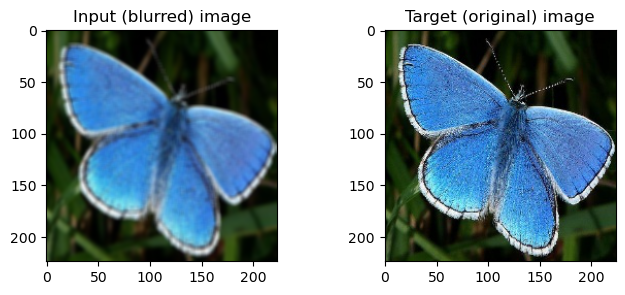

In [14]:
input_img, target_img = butterfly_train_dataset[0]
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].imshow(input_img.permute(1, 2, 0))
axes[0].set(title="Input (blurred) image")
axes[1].imshow(target_img.permute(1, 2, 0))
axes[1].set(title="Target (original) image");

### Example: ChestMNIST dataset

In [16]:
# Download the ChestMNIST dataset and move it from the current folder to the "../data" directory
# (ต้องติดตั้ง wget ก่อน (pip install wget))
!python -m wget https://zenodo.org/record/6496656/files/chestmnist.npz
!move chestmnist.npz ../data


Saved under chestmnist.npz
        1 file(s) moved.


In [17]:
# Import data
data_path = "../data/chestmnist.npz"
data = np.load(data_path)
print(data.files)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


เราต้องการปิดบาง pixel ของทุกภาพใน dataset เพื่อใช้เป็น input สำหรับการกู้ภาพคืน

In [18]:
class ChestMNIST(Dataset):
    """
    Class for masking the images of the ChestMNIST dataset.
    
    Parameters
    ----------
    data_path : str
    
        The path to the data.
        
    p : float
    
        A probability for a random mask.
        
    split : str
    
        A split argument to dictate what part of the data to load ("train", "validation", "test").
        
    transform: torchvision.transforms
    
        A transform to be applied to the data.
    
    """
    def __init__(self, data_path, p=0.5, transform=None, split="train"):
        self.data_path = data_path
        self.p = p
        self.transform = transform

        split_dict = {"train": "train_images", "validation": "val_images", "test": "test_images"}
        if split in split_dict:
            self.data = np.load(data_path)[split_dict[split]]
        else:
            raise ValueError("split parameter must be 'train', 'validation', or 'test'")

        # Transform to Tensor and add channel dimension
        self.data = torch.from_numpy(self.data).unsqueeze(1)

    def _get_mask(self, img_shape):
        """
        Generates a binary mask of the size of the sample to
        randomly erasesome data points based on the probability p.
        
        """
        c, w, h = img_shape
        masked_points = int((1 - self.p) * w * h)
        masked_idx = torch.randint(0, w * h, (masked_points,))
        mask = torch.ones((w * h))
        mask[masked_idx] = 0
        mask = mask.view(1, w, h)
        mask.repeat(c, 1, 1)
        return mask

    def __getitem__(self, idx):
        sample = self.data[idx]

        # Apply transforms
        if self.transform:
            sample = self.transform(sample)

        # Mask data
        mask = self._get_mask(sample.shape)
        masked_sample = sample * mask

        return masked_sample, sample

    def __len__(self):
        return len(self.data)

    def __str__(self):
        class_string = ""
        class_string += self.__class__.__name__
        class_string+="\n\t len : %d"%self.__len__()
        for key, value in self.__dict__.items():
            if key != "data" and key != "mask":
                class_string+="\n\t" + str(key) + " : " + str(value)
        return class_string

In [19]:
# Instantiate the class for a training set and a validation set
train_dataset = ChestMNIST(data_path, split="train")
val_dataset = ChestMNIST(data_path, split="validation")

In [20]:
# Print some information about the dataset
print(len(train_dataset), len(val_dataset))
print(train_dataset.data.shape)
print(train_dataset.data.min(), train_dataset.data.max())

78468 11219
torch.Size([78468, 1, 28, 28])
tensor(0, dtype=torch.uint8) tensor(253, dtype=torch.uint8)


In [21]:
# The number of pixels of an image
num_pixels = 28*28

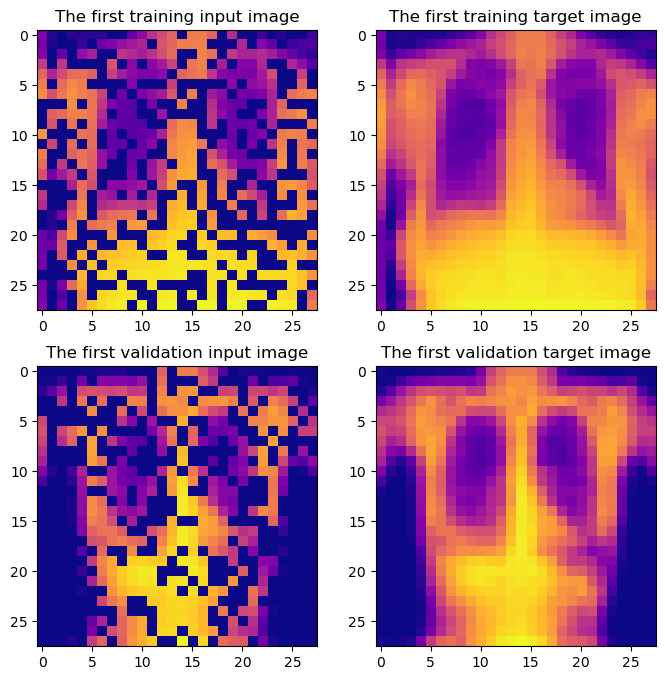

In [22]:
# Plot one input and output for each of these sets
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes[0][0].imshow(train_dataset[0][0][0], cmap="plasma")
axes[0][0].set(title="The first training input image")
axes[0][1].imshow(train_dataset[0][1][0], cmap="plasma")
axes[0][1].set(title="The first training target image")
axes[1][0].imshow(val_dataset[0][0][0], cmap="plasma")
axes[1][0].set(title="The first validation input image")
axes[1][1].imshow(val_dataset[0][1][0], cmap="plasma")
axes[1][1].set(title="The first validation target image");

In [23]:
class simpleFFN(nn.Module):
    """Class for a simple feed-forward network."""
    def __init__(self, input_size, hidden_size_1=200, hidden_size_2=100, hidden_size_3=100, hidden_size_4=200):
        super(simpleFFN, self).__init__()
        self.hidden_1 = nn.Linear(input_size, hidden_size_1, bias=False)
        self.hidden_2 = nn.Linear(hidden_size_1, hidden_size_2, bias=False)
        self.hidden_3 = nn.Linear(hidden_size_2, hidden_size_3, bias=False)
        self.hidden_4 = nn.Linear(hidden_size_3, hidden_size_4, bias=False)
        self.output = nn.Linear(hidden_size_4, input_size, bias=False)
        self.activation = nn.Mish()
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        z1 = self.hidden_1(X.flatten(start_dim=1))
        a1 = self.activation(z1)
        z2 = self.hidden_2(a1)
        a2 = self.activation(z2)
        z3 = self.hidden_3(a2)
        a3 = self.activation(z3)
        z4 = self.hidden_4(a3)
        a4 = self.activation(z4)
        z5 = self.output(a4)
        a5 = self.sigmoid(z5)
        return a5.view(X.shape)

In [24]:
model = simpleFFN(input_size=num_pixels).to(device)
summ = summary(model=model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         156,800
              Mish-2                  [-1, 200]               0
            Linear-3                  [-1, 100]          20,000
              Mish-4                  [-1, 100]               0
            Linear-5                  [-1, 100]          10,000
              Mish-6                  [-1, 100]               0
            Linear-7                  [-1, 200]          20,000
              Mish-8                  [-1, 200]               0
            Linear-9                  [-1, 784]         156,800
          Sigmoid-10                  [-1, 784]               0
Total params: 363,600
Trainable params: 363,600
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.39
Estimated T

In [25]:
# Hyperparameters
set_seed(42)
p = 0.6
lr = 1e-2
batch_size = 128
num_workers = 0
wd = 1e-6
n_epochs = 30

In [26]:
# Training set up
model = simpleFFN(
    input_size=num_pixels,
    hidden_size_1=150,
    hidden_size_2=50,
    hidden_size_3=50,
    hidden_size_4=150
).to(device)
optimiser = torch.optim.Adam(params=model.parameters(), lr=lr, weight_decay=wd)
mseloss = nn.MSELoss()

In [27]:
# Dataset and dataloader
transform = Compose([Lambda(lambda x: x/255.)])
train_dataset = ChestMNIST(data_path, split="train", p=p, transform=transform)
val_dataset = ChestMNIST(data_path, split="validation", p=p, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

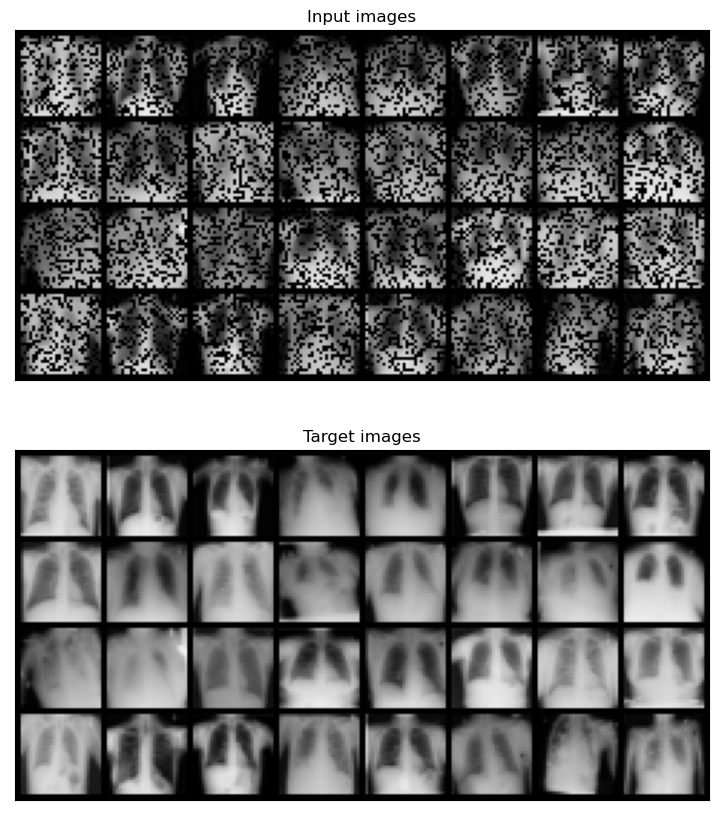

In [28]:
# Visualise a batch sample
inputs, targets = next(iter(train_loader))
input_grid = make_grid(inputs[:32])
target_grid = make_grid(targets[:32])

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].imshow(input_grid.permute(1, 2, 0))
axes[0].set(title="Input images", xticks=[], yticks=[])
axes[1].imshow(target_grid.permute(1, 2, 0))
axes[1].set(title="Target images", xticks=[], yticks=[]);

In [29]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss = 0.
    for inp, target in data_loader:
        inp, target = inp.to(device), target.to(device)
        optimizer.zero_grad()
        outp = model(inp)
        loss = criterion(outp, target)
        loss.backward()
        train_loss += loss*inp.size(0)
        optimizer.step()
    avg_train_loss = train_loss / len(data_loader.dataset)
    return avg_train_loss

def validate(model, criterion, data_loader):
    model.eval()
    val_loss = 0.
    with torch.no_grad():
        for inp, target in data_loader:
            inp, target = inp.to(device), target.to(device)
            outp = model(inp)
            loss = criterion(outp, target)
            val_loss += loss*inp.size(0)
        avg_val_loss = val_loss / len(data_loader.dataset)
        return avg_val_loss

In [26]:
# Compute log loss of the model and plot it over epoches
# You can use the "livelossplot" module to plot a real-time evolution of loss
train_losses, val_losses = [], []
for epoch in range(n_epochs):
    train_loss = train(model, optimiser, mseloss, train_loader)
    train_losses.append(train_loss.item())
    val_loss = validate(model, mseloss, val_loader)
    val_losses.append(val_loss.item())

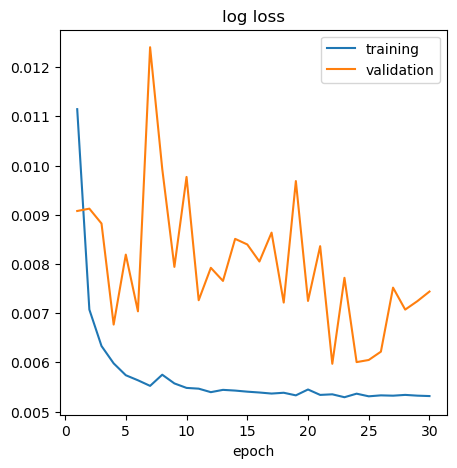

In [27]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(range(1, n_epochs+1), train_losses, label="training")
ax.plot(range(1, n_epochs+1), val_losses, label="validation")
ax.set(title="log loss", xlabel="epoch")
ax.legend();

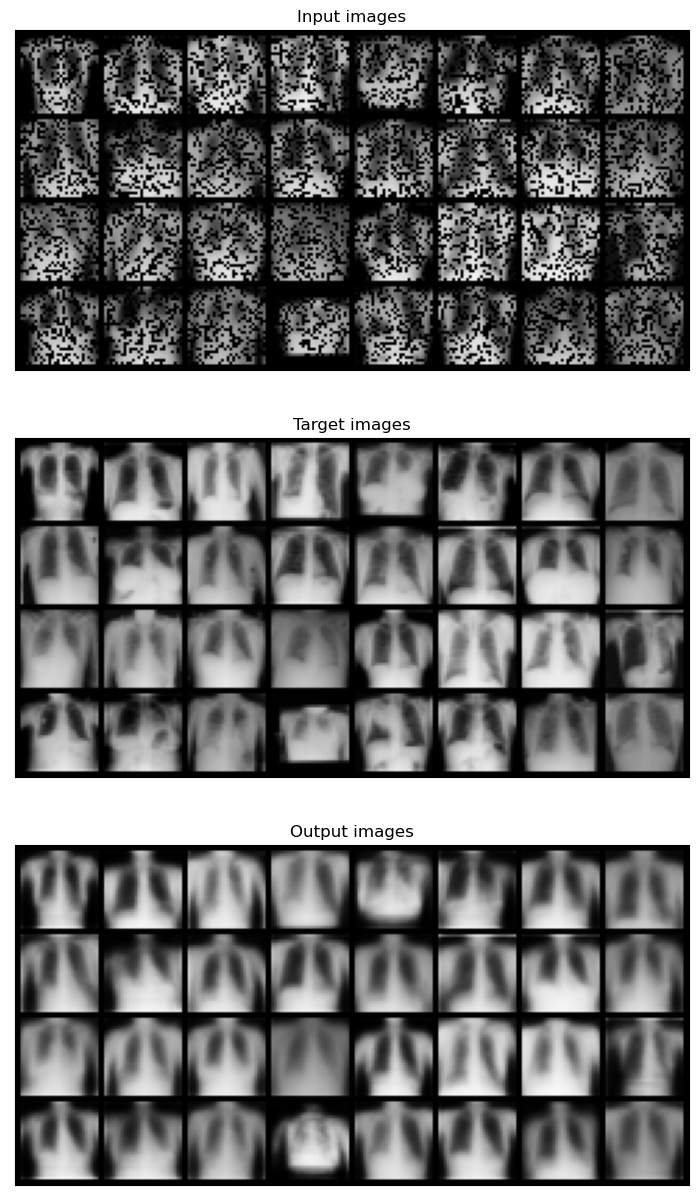

In [28]:
# Visualise 32 input, reconstructed and target samples from a validation batch
inputs, targets = next(iter(val_loader))
inputs, targets = inputs[:32], targets[:32]
outputs = model(inputs.to(device))

input_grid = make_grid(inputs)
output_grid = make_grid(outputs)
target_grid = make_grid(targets)

fig, axes = plt.subplots(3, 1, figsize=(25, 15))
axes[0].imshow(input_grid.detach().cpu().permute(1, 2, 0))
axes[0].set(title="Input images", xticks=[], yticks=[])
axes[1].imshow(target_grid.detach().cpu().permute(1, 2, 0))
axes[1].set(title="Target images", xticks=[], yticks=[])
axes[2].imshow(output_grid.detach().cpu().permute(1, 2, 0))
axes[2].set(title="Output images", xticks=[], yticks=[]);

In [29]:
# Pytorch stores all the parameters of models and optimizers, their weights and biases
# in an easy to read dictionary called a "state-dict".

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "->", model.state_dict()[param_tensor].size())

# Print optimiser's state_dict
print("\nOptimiser's state_dict:")
for var_name in optimiser.state_dict():
    print(var_name, "->", optimiser.state_dict()[var_name])

Model's state_dict:
hidden_1.weight -> torch.Size([150, 784])
hidden_2.weight -> torch.Size([50, 150])
hidden_3.weight -> torch.Size([50, 50])
hidden_4.weight -> torch.Size([150, 50])
output.weight -> torch.Size([784, 150])

Optimiser's state_dict:
state -> {0: {'step': tensor(18420.), 'exp_avg': tensor([[ 7.0417e-07,  3.1154e-07,  6.5955e-07,  ...,  1.0194e-05,
          9.8043e-06,  9.2225e-06],
        [-4.7063e-09,  1.1785e-09, -3.4386e-09,  ...,  8.2109e-09,
         -3.4130e-09, -2.5317e-09],
        [-4.9875e-09,  1.0603e-09, -3.7007e-09,  ...,  8.0137e-09,
         -4.0406e-09, -3.3319e-09],
        ...,
        [-5.2294e-09,  1.3292e-09, -3.8506e-09,  ...,  9.3408e-09,
         -3.3170e-09, -2.0317e-09],
        [-9.2062e-08,  2.3113e-08, -3.3543e-08,  ...,  5.0905e-08,
         -5.1181e-08, -6.9720e-09],
        [-3.1152e-08,  2.9160e-09, -2.0423e-08,  ...,  7.6678e-09,
         -4.2773e-08, -2.3818e-08]]), 'exp_avg_sq': tensor([[4.8138e-11, 3.8299e-11, 4.1255e-11,  ..., 5.33

In [30]:
# Save the model and the optimiser as .pt files
# (.pt and .pth files are common file extensions for saving models in pytorch)
storing_dir = "../data"  # Directory to store the files
model_filename = "chestmnist_simpleFFN_model.pt"
model_path = f"{storing_dir}/{model_filename}"
torch.save(model.state_dict(), model_path)
optimiser_filename = "chestmnist_simpleFFN_optimiser.pt"
optimiser_path = f"{storing_dir}/{optimiser_filename}"
torch.save(optimiser.state_dict(), optimiser_path)

In [31]:
# Create an instance of the model
model = simpleFFN(
    input_size=num_pixels,
    hidden_size_1=150,
    hidden_size_2=50,
    hidden_size_3=50,
    hidden_size_4=150
).to(device)
# Load the parameters of the model in path
model_path = f"../data/chestmnist_simpleFFN_model.pt"
model.load_state_dict(torch.load(model_path))
model.eval()
# Compute average validation loss
val_loss = validate(model, mseloss, val_loader)
print("Average validation loss = %1.3f" % val_loss.item())

Average validation loss = 0.007
